In [1]:
# imports and loadings
import os
import ast
import sys
sys.path.insert(0, '../functions/')
import create_data_for_single_gene as cdg
import interface_GAMS as iG
import parameter_optimization as po
import conversion_equations as ce
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import numpy as np
import pickle
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
genes = ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'] #'b1101', 'b1817', 'b1818', 'b1819', 
genes = ['b2818', 'b3958', 'b0273'] #'b1101', 'b1817', 'b1818', 'b1819', 
case = 'crp'
metabolite = 'AcetylN/ACoA' # Guanine, Hypoxanthine, AcetylN/ACoA

if not os.path.exists('../data/case_to_mRNA_passed.pkl'):
    case_to_mRNA_passed = {}
else:
    pickle_in = open('../data/case_to_mRNA_passed.pkl', 'rb')
    case_to_mRNA_passed = pickle.load(pickle_in)
    pickle_in.close()
    
# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
t_half_life_deg = 300
flags = { # add additional settings that should be changed between runs here
    # general flags
    'central_gene' : 'b1819',
    'force_rerun' : True,
    'sanity_plots' : True,
    'act_iM' : 'Crp-1',
    'inh_iM' : 'DhaR/Mlc',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'use_target_range' : False, # if True, adds a model parameter that encourages the cActivator range to match (cInhibitor is not affected by KdRNAPCrp and can't be adjusted for here)
    'target_range' : [-1, 3],
    'base_cInhibitor_val' : 0.2, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.2, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.2, # add this %age of the maximum to the top
    'cActivator' : [-4,2], # Uses a log10 range
    'cInhibitor': [-4,2], # Uses a log10 range
    'run_greedy' : True, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual
}
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
TF_flags_df = pd.read_csv('../data/TF_saved_flags.csv', index_col = 0)
stable_flags = { # these do not change gene by gene
    # overall
    'only_create_ratios' : False,
    'only_check_KdRNAPCrp' : False, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : 'argR', # only used for remove_outliers right now
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    
    # GAMs
    'limit_TF_conc_by_actual' : True, # limits the TF concentrations for the model by the actual values, otherwise lets it be a very wide range
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : genes, # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}

# proteomics data
starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
starve_metabs[starve_metabs.columns[1:]] *= 1e-6
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)

A = pd.read_csv('../data/validation_data_sets/merged_A.csv', index_col = 0)[starve_metabs.columns[1:]]

starved = [#'starve_series__t02_starve',
    #'starve_series__t03_starve',
    'starve_series__t06_starve',
    #'starve_series__t07_starve',
    'starve_series__t08_starve',
    'starve_series__t09_starve',
    'starve_series__t10_starve',
    'starve_series__t11_starve',
    'starve_series__t12_starve',
    #'starve_series__t14_starve',
    'starve_series__t16_starve',
    'starve_series__t17_starve',
    'starve_series__t18_starve',]

In [2]:
# setting for KdMetabolite
change_to_max = 50 # divide by this number

for index, row in TF_flags_df.iterrows():
    act_ct = 0
    inh_ct = 0
    for col in TF_flags_df.columns:
        if 'cAct' in col:
            act_ct += TF_flags_df.at[index, col]
        elif 'cInh' in col:
            inh_ct += TF_flags_df.at[index, col]
    if act_ct > 0:
        change_col = 'kd_act_metab'
    if inh_ct > 0:
        change_col = 'kd_inh_metab'
    metabolites = ast.literal_eval(row['effectors'])
    if len(metabolites) == 0:
        continue
    KdArg = max(starve_metabs.loc[metabolites][starve_metabs.columns[1:]].sum().values.flatten()) / change_to_max
    TF_flags_df.at[index, change_col] = KdArg
TF_flags_df.to_csv('../data/TF_saved_flags.csv')

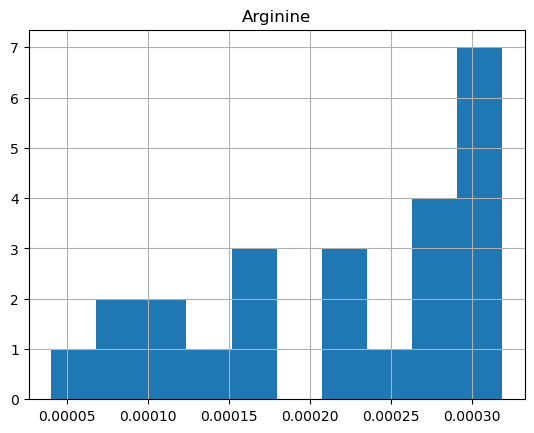

In [105]:
# let's compare differences between metabolites
iM = 'ArgR'
metabolite_we_care = [
 'Arginine',
  #  'Hypoxanthine',
  #  'Guanine',
 #   'AcetylN/ACoA',
]

starve_metabs.loc[metabolite_we_care][starve_metabs.columns[1:]].T.hist(sharex = True, sharey = True)
plt.show()

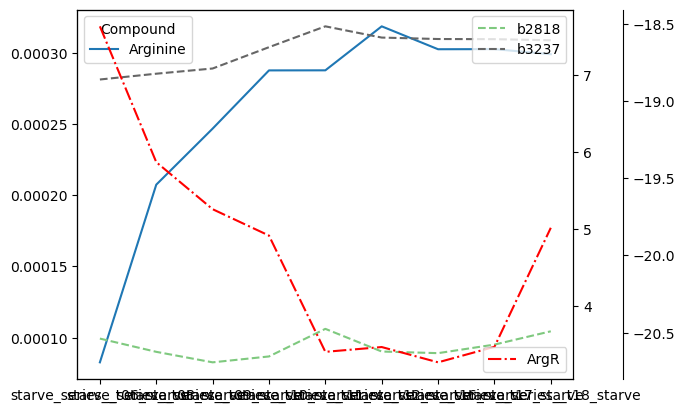

In [106]:
# look at the concentration over the experiment
fig, ax = plt.subplots()

ax1 = starve_metabs.loc[metabolite_we_care][starved].T.plot(ax = ax)

# let's overlay some expression

             
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
if iM == 'PurR-1':
    starve_log_tpm[starved].loc[['b1849', 'b1658']].T.plot(ax = ax2, colormap = 'Accent', ls = '--').legend(loc='upper right')
elif iM == 'ArgR':
    starve_log_tpm[starved].loc[['b2818', 'b3237']].T.plot(ax = ax2, colormap = 'Accent', ls = '--').legend(loc='upper right')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
A.loc[iM][starved].plot(ax=ax3, c = 'red', ls = 'dashdot').legend(loc = 'lower right')

plt.show()

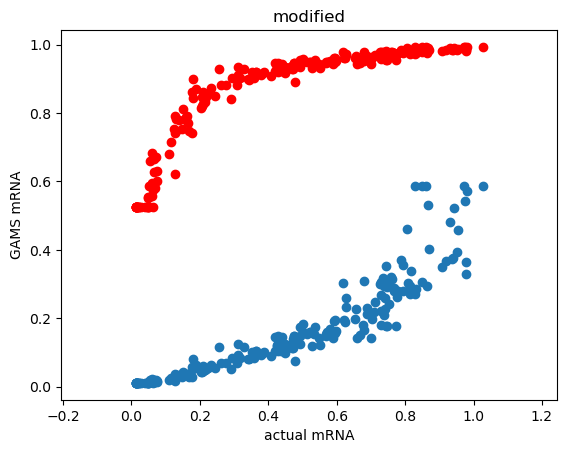

In [4]:
# testing out some stuff
run_vals = [int(f.split('_')[1]) for f in os.listdir('../GAMs/runs/') if 'run_' in f]
GAMs_run_dir = '../GAMs/runs/run_'+str(max(run_vals))

saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cInh_vals.csv', index_col = 0)

# GAMS calculated cActivators
kd_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cInh_Kd_results.csv', index_col = 0).astype(float).T

saved_cActivators = saved_cActivators[kd_df.columns]


# we are using the arginine model, so need to calculate cInhibitor using that
inh_metab = 10**pd.read_csv(GAMs_run_dir+'/output_files/inh_metab_Total.csv', index_col = 0).astype(float).T
input_constants = pd.read_csv(GAMs_run_dir+'/input_files/input_constants.csv', index_col = 0).astype(float)
KdArg = input_constants.loc['kd_inh_metab'].values[0]

TF_concs = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0).astype(float)

calc_cInh = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
cActs = []
for sample in calc_cInh.columns:
    ArgTotal = inh_metab[sample].values[0]
    TFTotal = TF_concs.loc[sample].values[0]
    for gene in calc_cInh.index:
        KdTF = kd_df[gene].values[0]

        calc_cInh.at[gene, sample] = (ArgTotal * KdTF + KdArg * KdTF +  KdTF * TFTotal + \
            ( -4 * ArgTotal * KdTF**2 * TFTotal + \
             (ArgTotal * KdTF + KdArg * KdTF + KdTF * TFTotal)**2)**.5 \
            ) / (2 * KdTF**2)
calc_cInh = calc_cInh.T

grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
vals = []
po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid['b2818']))
ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
ratios_df = ratios_df.loc[calc_cInh.index]
for cInh in calc_cInh['b2818']:
    vals.append(po.cActivator_cInhibitor_to_mRNA(0, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp']))
    
plt.axis('equal')
plt.scatter(ratios_df['b2818'], vals)
plt.xlabel('actual mRNA')
plt.ylabel('GAMS mRNA')
plt.title('pure')


# do it again, slightly modified in some way
# testing out some stuff
run_vals = [int(f.split('_')[1]) for f in os.listdir('../GAMs/runs/') if 'run_' in f]
GAMs_run_dir = '../GAMs/runs/run_'+str(max(run_vals))

saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cInh_vals.csv', index_col = 0)

# GAMS calculated cActivators
kd_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cInh_Kd_results.csv', index_col = 0).astype(float).T

saved_cActivators = saved_cActivators[kd_df.columns]


# we are using the arginine model, so need to calculate cInhibitor using that
inh_metab = 10**pd.read_csv(GAMs_run_dir+'/output_files/inh_metab_Total.csv', index_col = 0).astype(float).T
input_constants = pd.read_csv(GAMs_run_dir+'/input_files/input_constants.csv', index_col = 0).astype(float)
KdArg = input_constants.loc['kd_inh_metab'].values[0]

TF_concs = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0).astype(float)

calc_cInh = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
cActs = []
for sample in calc_cInh.columns:
    ArgTotal = inh_metab[sample].values[0]
    TFTotal = TF_concs.loc[sample].values[0]
    for gene in calc_cInh.index:
        KdTF = kd_df[gene].values[0] * 100

        calc_cInh.at[gene, sample] = (ArgTotal * KdTF + KdArg * KdTF +  KdTF * TFTotal + \
            ( -4 * ArgTotal * KdTF**2 * TFTotal + \
             (ArgTotal * KdTF + KdArg * KdTF + KdTF * TFTotal)**2)**.5 \
            ) / (2 * KdTF**2)
calc_cInh = calc_cInh.T

grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
vals = []
po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid['b2818']))
ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
ratios_df = ratios_df.loc[calc_cInh.index]
for cInh in calc_cInh['b2818']:
    vals.append(po.cActivator_cInhibitor_to_mRNA(0, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp']))
    
plt.axis('equal')
plt.scatter(ratios_df['b2818'], vals, c = 'red')
plt.xlabel('actual mRNA')
plt.ylabel('GAMS mRNA')
plt.title('modified')
plt.show()


plt.show()